In [1]:
import warnings

import os
import torch
import pickle
import numpy as np
import os.path as osp
from tqdm import tqdm

from functools import reduce
import torch.nn.functional as F
import matplotlib.pyplot as plt

from src.datasets import DatasetBuilder
from src.models.classifiers import SimpleCNNtorch
from src.models.vae import BetaVAE
from src.cf_methods import Revise
from src.evaluation.local_instability import perturb_sample
from src.utils import extract_factual_instances, filter_valid_factuals
from src.utils import seed_everything, get_config, load_model_weights
from src.utils import evaluate_classification_model, plot_boxplot

/data/leuven/365/vsc36567/miniconda3/lib/python3.12/site-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.6' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
2025-05-12 11:08:47.851951: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747040927.869693 3421241 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747040927.875196 3421241 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747040927.889763 3421241 computation_placer.cc:177] computation placer alrea

In [2]:
seed_everything()
warnings.filterwarnings("ignore", category=UserWarning)

In [3]:
config_path = r'/data/leuven/365/vsc36567/CF-Robustness-Benchmark/configs/revise_mnist_binary.yaml'
# r"D:\PycharmProjects\CF-Robustness-Benchmark\configs\revise_mnist_binary.yaml"
config = get_config(config_path)

In [4]:
ds_builder = DatasetBuilder(config)
ds_builder.setup()
train_loader, val_loader, test_loader = ds_builder.get_dataloaders()

In [5]:
os.makedirs(config.save_dir, exist_ok=True)
class_names = ds_builder.class_encodings
classes4fname = ("_").join([str(i) for i in class_names.values()]) if config.data.num_classes == 2 else ""
ds_name = config.data.name

### Load the classifier and VAE

In [6]:
baseline_classifier = SimpleCNNtorch(**config.classifier.args,
                                    img_size=config.data.img_size)
load_model_weights(baseline_classifier, weights_path=config.classifier.checkpoints_path)
evaluate_classification_model(baseline_classifier, test_loader, config.data.num_classes)

Accuracy for the test dataset: 99.265%


In [7]:
vae = BetaVAE(**config.vae.args, input_size=(config.data.img_size, config.data.img_size))
load_model_weights(vae, weights_path=config.vae.checkpoints_path)

In [9]:
config.vae.checkpoints_path

'/data/leuven/365/vsc36567/CF-Robustness-Benchmark/notebooks/experiments/mnist_vae/multiclass/checkpoints/mnist__epoch=05_total_loss=0.00.pth'

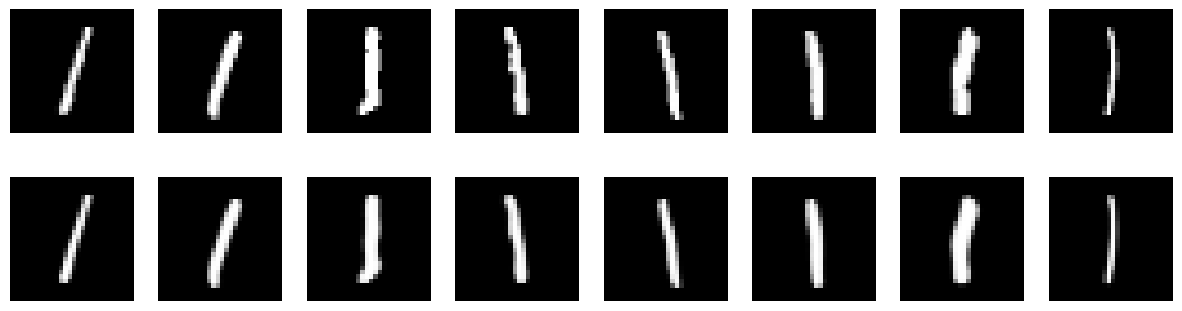

In [8]:
device = config.accelerator
vae = vae.to(device)
vae.eval()
with torch.no_grad():
    images, _ = next(iter(test_loader))
    images = images.to(device)

    z, _ = vae.encoder(images)
    recon_images = vae.decoder(z)
    recon_images = recon_images.to(device)

    # plot reconstructed images
    _, axes = plt.subplots(2, 8, figsize=(15, 4))
    for i in range(8):
        axes[0, i].imshow(images[i].permute(1, 2, 0).cpu().squeeze(), cmap='gray')
        axes[0, i].axis('off')
        axes[1, i].imshow(recon_images[i].permute(1, 2, 0).cpu().squeeze(), cmap='gray')
        axes[1, i].axis('off')

### Preparing factual test instances and their perturbed versions

In [10]:
factuals, labels = extract_factual_instances(test_loader, init_class_idx=0)
factuals, labels = filter_valid_factuals(factuals, labels, baseline_classifier)

In [11]:
# Checking for correctly predicted factuals 
preds = torch.argmax(baseline_classifier(factuals), axis=1)
print('Accuracy: {:.0%}'.format(torch.where(preds == labels)[0].shape[0] / factuals.shape[0]))

Accuracy: 100%


In [12]:
noise_magnitudes = [0.001, 0.0025, 0.005, 0.0075, 0.01]

Prepare perturbed factual instances for the generation of CFEs. We need those perturbed factuals that
are predicted correctly by the classifier

In [13]:
n = 100
factuals_pert = {}
indices_pert = {}

for noise in noise_magnitudes:
    pert_sample = perturb_sample(factuals, n_samples=1, noise_magnitude=noise)
    pert_sample = torch.Tensor(pert_sample)

    # Check whether perturbed instances lead to the same class prediction
    predictions = torch.argmax(baseline_classifier(pert_sample), axis=1).detach().cpu()
    indices = np.where(predictions == labels)[0]
    print(f'Number of valid perturbed factuals for the added noise level {noise}: ', indices.shape[0])
    factuals_pert[noise] = pert_sample
    indices_pert[noise] = indices

final_indices = reduce(np.intersect1d, list(indices_pert.values()))
factuals_pert = {k : v[final_indices][:n] for k, v in factuals_pert.items()}
factuals = factuals[final_indices][:n]
labels = labels[final_indices][:n]

Number of valid perturbed factuals for the added noise level 0.001:  1132
Number of valid perturbed factuals for the added noise level 0.0025:  1132
Number of valid perturbed factuals for the added noise level 0.005:  1132
Number of valid perturbed factuals for the added noise level 0.0075:  1132
Number of valid perturbed factuals for the added noise level 0.01:  1132


Visualize the factual instances perturbed with different noise magnitude

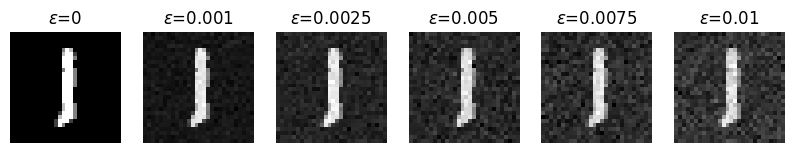

In [31]:
ind = 2
n_rows = 1
n_cols = len(noise_magnitudes) + 1
fig, axs = plt.subplots(n_rows, n_cols, figsize=(10, 4))

for j in range(n_cols):
    if j == 0: 
        axs[j].imshow(factuals[ind].squeeze().squeeze(), cmap='gray')
        axs[j].set_title('$\\epsilon$=0') 
        axs[j].axis('off')
    else:
        noise = noise_magnitudes[j-1]
        pert_image = factuals_pert[noise][ind].squeeze().squeeze() 
        axs[j].imshow(pert_image, cmap='gray')
        axs[j].set_title('$\\epsilon$='+str(noise)) 
        axs[j].axis('off')
        
plt.show()

# Generate CFEs

In [15]:
hparams = config.revise_hyperparameters
revise_method = Revise(baseline_classifier, vae, hparams)

In [16]:
cfes = revise_method.get_counterfactuals(factuals, verbose=False)

100%|██████████| 100/100 [04:03<00:00,  2.43s/it]


In [17]:
fname = f'cfes_{ds_name.lower()}_{classes4fname}_multivae.pkl'
with open(osp.join(config.save_dir, fname), 'wb') as f:
    pickle.dump(cfes, f)

In [48]:
fname = f'cfes_{ds_name.lower()}_{classes4fname}.pkl'
with open(osp.join(config.save_dir, fname), 'rb') as f:
    cfes = pickle.load(f)

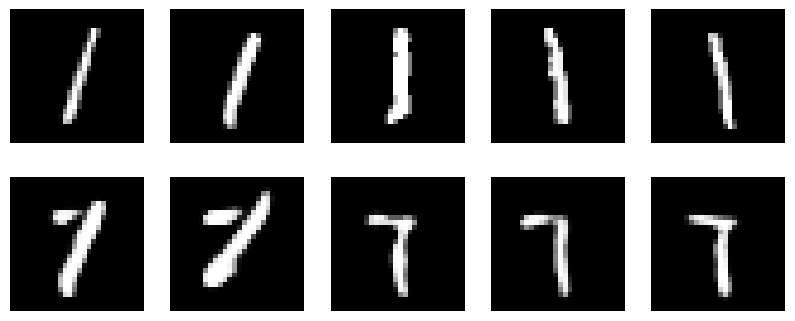

In [47]:
n_rows = 2
n_cols = 5

fig, axs = plt.subplots(n_rows, n_cols, figsize=(10, 4))
for i in range(n_rows):
    for j in range(n_cols):
        if i == 0: 
            pert_image = factuals[j].squeeze().squeeze()
            axs[i, j].imshow(pert_image, cmap='gray')
            axs[i, j].axis('off')
        elif i == 1:
            axs[i, j].imshow(cfes[j].squeeze(), cmap='gray')
            axs[i, j].axis('off')
plt.show()

In [24]:
predictions = torch.argmax(baseline_classifier(torch.Tensor(cfes).to('cuda')), axis=1).detach().cpu()
indices = np.where(predictions == torch.ones_like(predictions)*1)[0]
validity = indices.shape[0] / predictions.shape[0]
print(f'Validity: ',  validity)

Validity:  1.0


Read already generated CFEs

In [26]:
# cfes_pert = {} 

# for noise in noise_magnitudes:
#     cfes_pert[noise] = revise_method.get_counterfactuals(factuals_pert[noise], verbose=False)

#     fname = f'cfes_{ds_name.lower()}_{classes4fname}_noise_{noise}.pkl'
#     with open(osp.join(config.save_dir, fname), 'wb') as f:
#         pickle.dump(cfes_pert[noise], f)

100%|██████████| 100/100 [03:55<00:00,  2.36s/it]


Read already generated perturbed CFEs

In [49]:
cfes_pert = {} 

for noise in noise_magnitudes:
    fname = f'cfes_{ds_name.lower()}_{classes4fname}_noise_{noise}.pkl'
    with open(osp.join(config.save_dir, fname), 'rb') as f:
        cfes_pert[noise] = pickle.load(f)

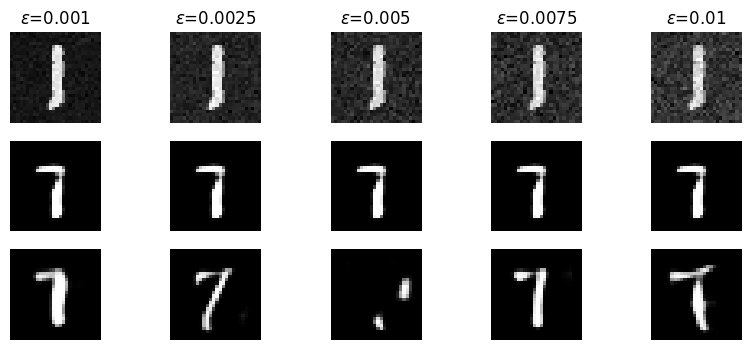

In [50]:
n_rows = 3
n_cols = 5

ind = 2

fig, axs = plt.subplots(n_rows, n_cols, figsize=(10, 4))
for i in range(n_rows):
    for j in range(n_cols):
        noise = noise_magnitudes[j]
        if i == 0: 
            pert_image = factuals_pert[noise][ind].squeeze().squeeze() 
            axs[i, j].imshow(pert_image, cmap='gray')
            axs[i, j].set_title('$\\epsilon$='+str(noise)) 
            axs[i, j].axis('off')
        elif i == 1:
            axs[i, j].imshow(cfes[ind].squeeze(), cmap='gray')
            axs[i, j].axis('off')
            axs[i, j].set_ylabel('CFE /wo noise')
        else:
            axs[i, j].imshow(cfes_pert[noise][ind].transpose(1, 2, 0), cmap='gray')
            # axs[i, j].set_title('epsilon='+str(noise)) 
            axs[i, j].axis('off')
            axs[i, j].set_ylabel('CFE /w noise')
plt.show()

## Local Instability

Checking validity of explanations after perturbation

In [52]:
target_cls_ind = 1

validity_dict = {}
for noise in noise_magnitudes:
    input_cfes = torch.Tensor(cfes_pert[noise]).to('cuda')
    predictions = torch.argmax(baseline_classifier(input_cfes), axis=1).detach().cpu()
    indices = np.where(predictions == torch.ones_like(predictions)*target_cls_ind)[0]
    validity = indices.shape[0] / predictions.shape[0]
    validity_dict[noise] = validity
    print(f'Validity for the added noise level {noise}: ',  validity)

fname = f'revise_{ds_name.lower()}_{classes4fname}_validity.pkl'
with open(osp.join(config.save_dir, fname), 'wb') as f:
    pickle.dump(validity_dict, f)

Validity for the added noise level 0.001:  1.0
Validity for the added noise level 0.0025:  1.0
Validity for the added noise level 0.005:  1.0
Validity for the added noise level 0.0075:  1.0
Validity for the added noise level 0.01:  1.0


In [53]:
from src.evaluation.local_instability import calculate_sparsity, calculate_ssim

In [54]:
instability_l1_list = []
ssim_list = []

for noise, cfe_pert_list in cfes_pert.items():
    l1_temp = []
    ssim_temp = []
    for i in range(len(cfes)):
        cf = cfes[i]
        cf_pert = cfe_pert_list[i]

        if len(cf) != 0 and len(cf_pert) != 0:

            cf_tensor = torch.Tensor(cf)
            cf = cf_tensor.permute(1, 2, 0).flatten()

            cf_pert_tensor = torch.Tensor(cf_pert)
            cf_perturbed = cf_pert_tensor.permute(1, 2, 0).flatten()        

            l1_distance = sum(abs(cf - cf_perturbed)) # np.linalg.norm(cf.flatten() - cf_perturbed.flatten(), ord=1)
            l1_temp.append(l1_distance)

            ssim = calculate_ssim(cf_tensor.unsqueeze(0), cf_pert_tensor.unsqueeze(0)).item()
            ssim_temp.append(ssim)

    instability_l1_list.append(l1_temp)
    ssim_list.append(ssim_temp)

# with open(osp.join(config.save_dir, f'revise_{ds_name.lower()}_{classes4fname}_li_l1_.pkl'), 'wb') as f:
#     pickle.dump(instability_l1_list, f)

# with open(osp.join(config.save_dir, f'revise_{ds_name.lower()}_{classes4fname}_ssim.pkl'), 'wb') as f:
#     pickle.dump(ssim_list, f)

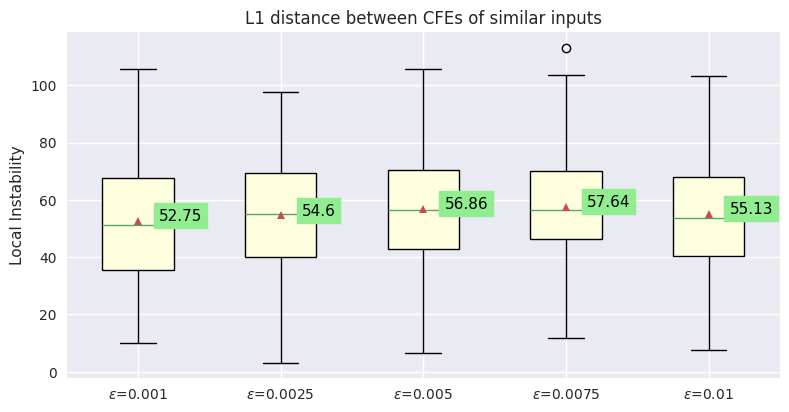

In [55]:
plt.style.use("seaborn-v0_8")
plt.rcParams['figure.figsize'] = [8, 4]

plot_boxplot(data=instability_l1_list, mean_values=np.round(np.mean(instability_l1_list, axis=1), 2),
             tick_labels=[f'$\\epsilon$={noise_level}' for noise_level in noise_magnitudes],
             y_label='Local Instability', colors=['lightyellow'], title='L1 distance between CFEs of similar inputs')

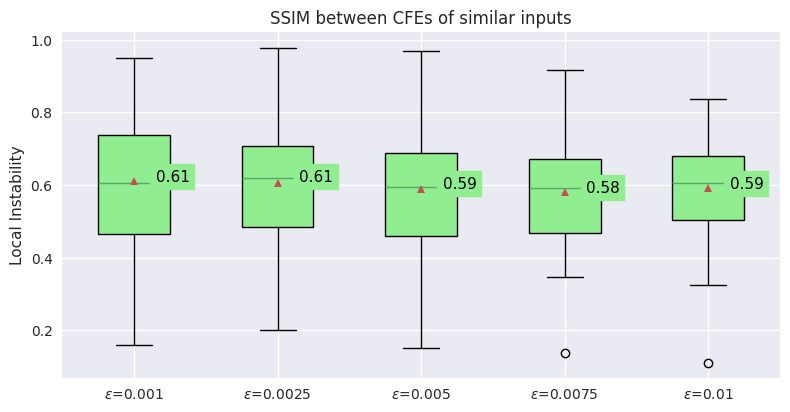

In [56]:
plot_boxplot(data=ssim_list, mean_values=np.round(np.mean(ssim_list, axis=1), 2),
             tick_labels=[f'$\\epsilon$={noise_level}' for noise_level in noise_magnitudes],
             y_label='Local Instability', colors=['lightgreen'], title='SSIM between CFEs of similar inputs')

## Local Lipschitz Continuity

In [24]:
original_points = factuals
original_cfes = cfes
print("Are the lengths of initial points (factuals) and CFEs generated for them equal :", len(original_cfes) == original_points.shape[0])

Are the lengths of initial points (factuals) and CFEs generated for them equal : True


In [25]:
noise_magnitude = 0.001
n_samples = 30
revise_method._params["max_iter"] = 400

lip_estimates = []

i = 0
for original_point, original_cfe in tqdm(zip(original_points[:n_samples], original_cfes[:n_samples])):

    neighbor_points = perturb_sample(original_point.unsqueeze(0), 
                                     n_samples=30, 
                                     noise_magnitude=noise_magnitude)    
    neighbor_points = torch.Tensor(neighbor_points)
    neighbor_cfes = revise_method.get_counterfactuals(neighbor_points, verbose=False)

    lip_estimate = 0
    for m, p in tqdm(zip(neighbor_cfes, neighbor_points)):
        if not isinstance(m, list):
            num = np.linalg.norm((original_cfe - m).flatten(), ord=2) 
            denom = np.linalg.norm((original_point - p).flatten(), ord=2)
            lip = num / denom
            lip_estimate = max(lip, lip_estimate)

    lip_estimates.append(lip_estimate)
    i += 1

 20%|██        | 6/30 [00:16<01:05,  2.74s/it]
0it [00:16, ?it/s]


KeyboardInterrupt: 

In [ ]:
with open(osp.join(config.save_dir, f'revise_{ds_name.lower()}_{classes4fname}_lle.pkl'), 'wb') as f:
        pickle.dump(lip_estimates, f)

## Invalidation Rate

In [57]:
classifiers_weights_dir = r"/data/leuven/365/vsc36567/CF-Robustness-Benchmark/notebooks/experiments/mnist_classification/binary/checkpoints/mc_1_7"
# r'D:\PycharmProjects\CF-Robustness-Benchmark\notebooks\experiments\mnist_classification\binary\checkpoints\mc_1_7'

classifiers_list = []
for clf_weights in os.listdir(classifiers_weights_dir):
    cnn_perturbed = SimpleCNNtorch(**config.classifier.args,
                                    img_size=config.data.img_size)
    load_model_weights(model=cnn_perturbed, 
                        weights_path=osp.join(classifiers_weights_dir, clf_weights))
    classifiers_list.append(cnn_perturbed)
    evaluate_classification_model(cnn_perturbed, 
                                dataloader=test_loader, 
                                num_classes=config.data.num_classes)

Accuracy for the test dataset: 99.632%
Accuracy for the test dataset: 99.173%
Accuracy for the test dataset: 99.311%
Accuracy for the test dataset: 99.403%
Accuracy for the test dataset: 99.311%
Accuracy for the test dataset: 99.540%
Accuracy for the test dataset: 99.311%
Accuracy for the test dataset: 99.494%
Accuracy for the test dataset: 99.586%
Accuracy for the test dataset: 99.449%


In [58]:
target_class = 1
validity_list = []
invalidation_rate_list = []
device = 'cuda' if torch.cuda.is_available() else 'cpu'

for i, classifier in enumerate(classifiers_list):
    validity = 0
    invalidation_rate = 0
    total_found_cfs = 0
    
    for cfe in cfes:
        if isinstance(cfe, list):
            continue
        
        cfe = torch.Tensor(cfe).unsqueeze(0).to(device)
        classifier.eval()
        with torch.no_grad():
            classifier = classifier.to(device)

            baseline_pred = torch.argmax(baseline_classifier(cfe), axis=1)
            alternative_pred = torch.argmax(classifier(cfe), axis=1)

        total_found_cfs += 1

        if baseline_pred != alternative_pred:
            invalidation_rate += 1

        if alternative_pred == target_class:
                validity += 1

    invalidation_rate /= total_found_cfs
    invalidation_rate_list.append(invalidation_rate)
    validity_list.append(validity / total_found_cfs)
    print(f'Model {i}: IR={invalidation_rate}, validity={validity}')

print('Average IR : {:.3f} +- {:.3f}'.format(np.mean(invalidation_rate_list), np.std(invalidation_rate_list)))
print('Average VaR : {:.3f} +- {:.3f}'.format(np.mean(validity_list), np.std(validity_list)))

Model 0: IR=0.18, validity=82
Model 1: IR=0.1, validity=90
Model 2: IR=0.05, validity=95
Model 3: IR=0.27, validity=73
Model 4: IR=0.04, validity=96
Model 5: IR=0.19, validity=81
Model 6: IR=0.01, validity=99
Model 7: IR=0.04, validity=96
Model 8: IR=0.18, validity=82
Model 9: IR=0.17, validity=83
Average IR : 0.123 +- 0.082
Average VaR : 0.877 +- 0.082


## Relaxed Stability

In [25]:
k = 1000
sigma = 0.001
device = 'cuda' if torch.cuda.is_available() else 'cpu'

average_stability_list = []
for i, classifier in enumerate(classifiers_list):
    stability_list = []
    for cfe in cfes:
        if isinstance(cfe, list):
            continue

        cfe = torch.Tensor(cfe).unsqueeze(0)
        cfe_sampled = torch.Tensor(perturb_sample(cfe, n_samples=k, noise_magnitude=sigma))

        with torch.no_grad():
            cf_logits = classifier(cfe.to(device))
            cf_probabilities = F.softmax(cf_logits, dim=-1)[:, target_class]

            cf_sampled_logits = classifier(cfe_sampled.to(device))
            cf_sampled_probabilities = F.softmax(cf_sampled_logits, dim=-1)[:, target_class]
        
        model_variance = abs(cf_probabilities - cf_sampled_probabilities)

        stability = (cf_sampled_probabilities - model_variance).mean()
        stability_list.append(stability.item())

    avg_i_stability = np.mean(stability_list)
    print('Stability of the model {}: {:.3f} +- {:.3f}'.format(i, avg_i_stability.item(), np.std(stability_list).item()))
    average_stability_list.append(avg_i_stability)

Stability of the model 0: 0.848 +- 0.304
Stability of the model 1: 0.811 +- 0.206
Stability of the model 2: 0.811 +- 0.244
Stability of the model 3: 0.614 +- 0.297
Stability of the model 4: 0.866 +- 0.255
Stability of the model 5: 0.820 +- 0.318
Stability of the model 6: 0.956 +- 0.088
Stability of the model 7: 0.896 +- 0.227
Stability of the model 8: 0.834 +- 0.318
Stability of the model 9: 0.775 +- 0.308


In [26]:
print('Average RS: {:.3f} +- {:.3f}'.format(np.mean(average_stability_list), np.std(average_stability_list)))

Average RS: 0.823 +- 0.085
